In [20]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

TRADING_DAYS = 252


# ----------------------------
# Helpers: robust 1D series extraction
# ----------------------------
def to_series(x, name: str = "") -> pd.Series:
    """
    Convert x to a 1D pandas Series.
    - If x is a Series: return as is
    - If x is a 1-col DataFrame: squeeze to Series
    - Else: raise
    """
    if isinstance(x, pd.Series):
        return x
    if isinstance(x, pd.DataFrame):
        if x.shape[1] != 1:
            raise ValueError(f"{name}: expected 1-col DataFrame, got shape={x.shape}")
        return x.iloc[:, 0]
    raise ValueError(f"{name}: expected Series or 1-col DataFrame, got {type(x)}")


def get_price_column(df: pd.DataFrame, field: str, ticker: str = None) -> pd.Series:
    """
    Robustly extract a price column as a Series from yfinance output.
    Works for:
    - single-index columns: df['Close']
    - multi-index columns: df[('Close','SPY')] or df['Close'] giving (T,1) DataFrame
    """
    if field not in df.columns and not isinstance(df.columns, pd.MultiIndex):
        # single-index but missing
        raise KeyError(f"Missing column '{field}'. Available: {list(df.columns)}")

    if isinstance(df.columns, pd.MultiIndex):
        # yfinance may return columns like (PriceField, Ticker)
        if ticker is not None and (field, ticker) in df.columns:
            return to_series(df[(field, ticker)], name=f"{field}-{ticker}")
        # else try df[field] which may be a 1-col DataFrame
        if field in df.columns.get_level_values(0):
            return to_series(df[field], name=field)
        raise KeyError(f"Could not locate '{field}' in MultiIndex columns.")
    else:
        return to_series(df[field], name=field)


# ----------------------------
# Data helper (fix the warning too)
# ----------------------------
def download_price(ticker: str, start: str, end: str) -> pd.DataFrame:
    import yfinance as yf
    df = yf.download(
        ticker,
        start=start,
        end=end,
        auto_adjust=False,   # explicit to avoid default-change warning
        progress=False
    )
    if df is None or df.empty:
        raise ValueError(f"No data returned for {ticker}.")
    return df.sort_index()


# ----------------------------
# Indicators
# ----------------------------
def ema(s: pd.Series, span: int) -> pd.Series:
    s = to_series(s, name="ema_input")
    return s.ewm(span=span, adjust=False, min_periods=span).mean()


def macd(close: pd.Series, fast: int = 12, slow: int = 26, signal: int = 9) -> pd.DataFrame:
    """
    MACD computed on 1D close series.
    Returns DataFrame with columns: macd_line, macd_signal, macd_hist
    """
    close = to_series(close, name="close")
    fast_ema = ema(close, fast)
    slow_ema = ema(close, slow)
    macd_line = fast_ema - slow_ema
    macd_signal = ema(macd_line, signal)
    macd_hist = macd_line - macd_signal
    return pd.DataFrame(
        {"macd_line": macd_line, "macd_signal": macd_signal, "macd_hist": macd_hist},
        index=close.index,
    )


# ----------------------------
# Signal rules
# ----------------------------
def macd_cross_long_flat(ind: pd.DataFrame) -> pd.Series:
    """
    Long when MACD line > signal line, flat otherwise.
    Signal is computed using data available at close[t].
    """
    sig = (ind["macd_line"] > ind["macd_signal"]).astype(int)
    return sig.rename("raw_signal")


# ----------------------------
# Performance utilities
# ----------------------------
def annualised_return_geo(r: pd.Series, freq: int = TRADING_DAYS) -> float:
    r = to_series(r, name="returns").dropna()
    if len(r) == 0:
        return np.nan
    eq = (1.0 + r).prod()
    return float(eq ** (freq / len(r)) - 1.0)


def annualised_vol(r: pd.Series, freq: int = TRADING_DAYS) -> float:
    r = to_series(r, name="returns").dropna()
    if len(r) < 2:
        return np.nan
    return float(r.std(ddof=1) * np.sqrt(freq))


def sharpe_ratio(r: pd.Series, freq: int = TRADING_DAYS, rf: float = 0.0) -> float:
    r = to_series(r, name="returns").dropna()
    if len(r) < 2:
        return np.nan
    rf_per = rf / freq
    ex = r - rf_per
    vol = ex.std(ddof=1) * np.sqrt(freq)
    vol = float(vol)
    if vol == 0.0 or not np.isfinite(vol):
        return np.nan
    return float(ex.mean() * freq / vol)


def max_drawdown(r: pd.Series) -> float:
    r = to_series(r, name="returns").fillna(0.0)
    eq = (1.0 + r).cumprod()
    dd = eq / eq.cummax() - 1.0
    return float(dd.min())


def perf_summary(r: pd.Series, freq: int = TRADING_DAYS, rf: float = 0.0) -> dict:
    r = to_series(r, name="returns")
    return {
        "ann_return_geo": annualised_return_geo(r, freq=freq),
        "ann_vol": annualised_vol(r, freq=freq),
        "sharpe": sharpe_ratio(r, freq=freq, rf=rf),
        "max_dd": max_drawdown(r),
        "n_obs": int(r.dropna().shape[0]),
    }


# ----------------------------
# Backtest engine (single asset) + benchmark
# ----------------------------
def backtest_single_asset(
    price: pd.DataFrame,
    raw_signal: pd.Series,
    entry: str = "next_close",
    cost_bps: float = 5.0,
    rf: float = 0.0,
    benchmark: str = "buy_hold",
) -> dict:
    """
    Single-asset backtest with no look-ahead:
      - signal computed at close[t]
      - position applied on t+1 (shift by 1)

    Includes benchmark (default buy & hold same asset).
    """
    price = price.sort_index()

    # Extract px series robustly
    if entry == "next_close":
        px = get_price_column(price, "Close")
        asset_ret = px.pct_change(fill_method=None)
    elif entry == "next_open":
        px = get_price_column(price, "Open")
        asset_ret = px.pct_change(fill_method=None)
    else:
        raise ValueError("entry must be 'next_close' or 'next_open'")

    raw_signal = to_series(raw_signal, name="raw_signal").reindex(price.index).astype(float)

    # Position used at time t is decided at t-1 close
    position = raw_signal.shift(1)

    # Costs: apply when position changes (per unit turnover)
    turnover = position.diff().abs().fillna(0.0)
    cost = (cost_bps / 10000.0) * turnover

    strat_ret_gross = position * asset_ret
    strat_ret_net = strat_ret_gross - cost

    equity_gross = (1.0 + strat_ret_gross.fillna(0.0)).cumprod()
    equity_net = (1.0 + strat_ret_net.fillna(0.0)).cumprod()

    # Benchmark: buy & hold same asset under same return convention
    if benchmark == "buy_hold":
        bench_ret = asset_ret.copy()
    else:
        raise ValueError("For now benchmark must be 'buy_hold' (same asset).")

    bench_equity = (1.0 + bench_ret.fillna(0.0)).cumprod()

    out = {
        "asset_ret": asset_ret,
        "raw_signal": raw_signal,
        "position": position,
        "turnover": turnover,
        "cost": cost,
        "strategy_ret_gross": strat_ret_gross,
        "strategy_ret_net": strat_ret_net,
        "equity_gross": equity_gross,
        "equity_net": equity_net,
        "benchmark_ret": bench_ret,
        "benchmark_equity": bench_equity,
        "stats_gross": perf_summary(strat_ret_gross, rf=rf),
        "stats_net": perf_summary(strat_ret_net, rf=rf),
        "stats_benchmark": perf_summary(bench_ret, rf=rf),
    }
    return out

In [24]:
import numpy as np
import pandas as pd
from typing import Dict, Any, Iterable, Tuple, Optional, List


TRADING_DAYS = 252


# ============================================================
# Robust helpers: ensure 1D Series from yfinance outputs
# ============================================================

def to_series(x, name: str = "") -> pd.Series:
    if isinstance(x, pd.Series):
        return x
    if isinstance(x, pd.DataFrame):
        if x.shape[1] != 1:
            raise ValueError(f"{name}: expected 1-col DataFrame, got shape={x.shape}")
        return x.iloc[:, 0]
    raise ValueError(f"{name}: expected Series or 1-col DataFrame, got {type(x)}")


def get_price_column(df: pd.DataFrame, field: str, ticker: Optional[str] = None) -> pd.Series:
    """
    Works for:
      - single-index columns: df['Close']
      - multi-index columns: df[('Close','SPY')] or df['Close'] giving (T,1) DataFrame
    """
    if isinstance(df.columns, pd.MultiIndex):
        if ticker is not None and (field, ticker) in df.columns:
            return to_series(df[(field, ticker)], name=f"{field}-{ticker}")
        # try df[field] (often 1-col DF)
        if field in df.columns.get_level_values(0):
            return to_series(df[field], name=field)
        raise KeyError(f"Could not locate '{field}' in MultiIndex columns.")
    else:
        if field not in df.columns:
            raise KeyError(f"Missing column '{field}'. Available: {list(df.columns)}")
        return to_series(df[field], name=field)


# ============================================================
# Indicators
# ============================================================

def ema(s: pd.Series, span: int) -> pd.Series:
    s = to_series(s, name="ema_input")
    return s.ewm(span=span, adjust=False, min_periods=span).mean()


def macd_indicator(close: pd.Series, fast: int = 12, slow: int = 26, signal: int = 9) -> pd.DataFrame:
    close = to_series(close, name="close")
    fast_ema = ema(close, fast)
    slow_ema = ema(close, slow)
    macd_line = fast_ema - slow_ema
    macd_sig = ema(macd_line, signal)
    macd_hist = macd_line - macd_sig
    return pd.DataFrame(
        {"macd_line": macd_line, "macd_signal": macd_sig, "macd_hist": macd_hist},
        index=close.index,
    )


# ============================================================
# Strategy rules (signals -> positions)
# ============================================================

def macd_cross_long_flat(ind: pd.DataFrame) -> pd.Series:
    """
    Long (1) when MACD line > signal line, flat (0) otherwise.
    Signal is computed on close[t] and applied from t+1 in backtest.
    """
    return (ind["macd_line"] > ind["macd_signal"]).astype(int).rename("raw_signal")


# ============================================================
# Performance utilities
# ============================================================

def annualised_return_geo(r: pd.Series, freq: int = TRADING_DAYS) -> float:
    r = to_series(r, name="returns").dropna()
    if len(r) == 0:
        return np.nan
    eq = (1.0 + r).prod()
    return float(eq ** (freq / len(r)) - 1.0)


def annualised_vol(r: pd.Series, freq: int = TRADING_DAYS) -> float:
    r = to_series(r, name="returns").dropna()
    if len(r) < 2:
        return np.nan
    return float(r.std(ddof=1) * np.sqrt(freq))


def sharpe_ratio(r: pd.Series, freq: int = TRADING_DAYS, rf: float = 0.0) -> float:
    r = to_series(r, name="returns").dropna()
    if len(r) < 2:
        return np.nan
    rf_per = rf / freq
    ex = r - rf_per
    vol = ex.std(ddof=1) * np.sqrt(freq)
    vol = float(vol)
    if vol == 0.0 or not np.isfinite(vol):
        return np.nan
    return float(ex.mean() * freq / vol)


def max_drawdown(r: pd.Series) -> float:
    r = to_series(r, name="returns").fillna(0.0)
    eq = (1.0 + r).cumprod()
    dd = eq / eq.cummax() - 1.0
    return float(dd.min())


def perf_summary(r: pd.Series, freq: int = TRADING_DAYS, rf: float = 0.0) -> Dict[str, float]:
    r = to_series(r, name="returns")
    return {
        "ann_return_geo": annualised_return_geo(r, freq=freq),
        "ann_vol": annualised_vol(r, freq=freq),
        "sharpe": sharpe_ratio(r, freq=freq, rf=rf),
        "max_dd": max_drawdown(r),
        "n_obs": int(r.dropna().shape[0]),
    }


# ============================================================
# Single-asset backtest engine + benchmark
# ============================================================

def backtest_single_asset(
    price: pd.DataFrame,
    raw_signal: pd.Series,
    entry: str = "next_close",
    cost_bps: float = 5.0,
    rf: float = 0.0,
) -> Dict[str, Any]:
    """
    No look-ahead:
      - signal computed at close[t]
      - position applied at t+1 via position = signal.shift(1)

    Benchmark: buy & hold same asset under same return convention.
    """
    price = price.sort_index()
    raw_signal = to_series(raw_signal, name="raw_signal").reindex(price.index).astype(float)

    if entry == "next_close":
        px = get_price_column(price, "Close")
        asset_ret = px.pct_change(fill_method=None)
    elif entry == "next_open":
        px = get_price_column(price, "Open")
        asset_ret = px.pct_change(fill_method=None)
    else:
        raise ValueError("entry must be 'next_close' or 'next_open'")

    # Apply position from next day
    position = raw_signal.shift(1)

    turnover = position.diff().abs().fillna(0.0)
    cost = (cost_bps / 10000.0) * turnover

    strat_ret_gross = position * asset_ret
    strat_ret_net = strat_ret_gross - cost

    bench_ret = asset_ret.copy()

    out = {
        "asset_ret": asset_ret,
        "raw_signal": raw_signal,
        "position": position,
        "turnover": turnover,
        "cost": cost,
        "strategy_ret_gross": strat_ret_gross,
        "strategy_ret_net": strat_ret_net,
        "benchmark_ret": bench_ret,
        "equity_gross": (1.0 + strat_ret_gross.fillna(0.0)).cumprod(),
        "equity_net": (1.0 + strat_ret_net.fillna(0.0)).cumprod(),
        "benchmark_equity": (1.0 + bench_ret.fillna(0.0)).cumprod(),
        "stats_gross_full": perf_summary(strat_ret_gross, rf=rf),
        "stats_net_full": perf_summary(strat_ret_net, rf=rf),
        "stats_benchmark_full": perf_summary(bench_ret, rf=rf),
    }
    return out


# ============================================================
# Train/Test utilities
# ============================================================

def slice_period(s: pd.Series, start: str, end: str) -> pd.Series:
    s = to_series(s)
    # inclusive slicing for DatetimeIndex
    return s.loc[pd.to_datetime(start):pd.to_datetime(end)]


def train_test_stats(
    bt: Dict[str, Any],
    train_start: str,
    train_end: str,
    test_start: str,
    test_end: str,
    rf: float = 0.0,
) -> Dict[str, Any]:
    """
    Compute train/test performance summaries for:
      - strategy net
      - strategy gross
      - benchmark (buy&hold)
    """
    net = bt["strategy_ret_net"]
    gross = bt["strategy_ret_gross"]
    bench = bt["benchmark_ret"]

    net_tr = slice_period(net, train_start, train_end)
    gross_tr = slice_period(gross, train_start, train_end)
    bench_tr = slice_period(bench, train_start, train_end)

    net_te = slice_period(net, test_start, test_end)
    gross_te = slice_period(gross, test_start, test_end)
    bench_te = slice_period(bench, test_start, test_end)

    return {
        "train": {
            "net": perf_summary(net_tr, rf=rf),
            "gross": perf_summary(gross_tr, rf=rf),
            "benchmark": perf_summary(bench_tr, rf=rf),
        },
        "test": {
            "net": perf_summary(net_te, rf=rf),
            "gross": perf_summary(gross_te, rf=rf),
            "benchmark": perf_summary(bench_te, rf=rf),
        },
        "meta": {
            "train_start": train_start,
            "train_end": train_end,
            "test_start": test_start,
            "test_end": test_end,
        },
    }


# ============================================================
# Best-params search (MACD grid search)
# ============================================================

def find_best_macd_params(
    price: pd.DataFrame,
    train_start: str,
    train_end: str,
    test_start: str,
    test_end: str,
    fast_grid: Iterable[int] = (8, 12, 16),
    slow_grid: Iterable[int] = (20, 26, 32, 40),
    signal_grid: Iterable[int] = (6, 9, 12),
    entry: str = "next_close",
    cost_bps: float = 5.0,
    rf: float = 0.0,
    objective: str = "train_sharpe_net",
    min_train_obs: int = 252,
) -> pd.DataFrame:
    """
    Grid-search MACD parameters using TRAIN period only for selection,
    then report TEST performance for the same params.

    objective options:
      - 'train_sharpe_net'
      - 'train_ann_return_net'
      - 'train_calmar_net' (not implemented here; can add if you want)

    Returns a DataFrame sorted by objective (descending).
    """
    price = price.sort_index()
    close = get_price_column(price, "Close")

    rows: List[Dict[str, Any]] = []

    for fast in fast_grid:
        for slow in slow_grid:
            if fast >= slow:
                continue
            for sig_span in signal_grid:
                # Build indicator + signal on full history (uses only past data)
                ind = macd_indicator(close, fast=fast, slow=slow, signal=sig_span)
                sig = macd_cross_long_flat(ind)

                bt = backtest_single_asset(
                    price=price,
                    raw_signal=sig,
                    entry=entry,
                    cost_bps=cost_bps,
                    rf=rf,
                )

                # Train/test stats
                stats = train_test_stats(
                    bt,
                    train_start=train_start,
                    train_end=train_end,
                    test_start=test_start,
                    test_end=test_end,
                    rf=rf,
                )

                train_net = stats["train"]["net"]
                test_net = stats["test"]["net"]

                # Enforce enough train observations (avoid picking params on tiny samples)
                if train_net["n_obs"] < min_train_obs:
                    continue

                if objective == "train_sharpe_net":
                    score = train_net["sharpe"]
                elif objective == "train_ann_return_net":
                    score = train_net["ann_return_geo"]
                else:
                    raise ValueError("Unsupported objective. Use 'train_sharpe_net' or 'train_ann_return_net'.")

                rows.append({
                    "fast": fast,
                    "slow": slow,
                    "signal": sig_span,
                    "objective": objective,
                    "score": float(score) if score is not None else np.nan,

                    # train net
                    "train_ann_return_net": train_net["ann_return_geo"],
                    "train_ann_vol_net": train_net["ann_vol"],
                    "train_sharpe_net": train_net["sharpe"],
                    "train_max_dd_net": train_net["max_dd"],
                    "train_n_obs": train_net["n_obs"],

                    # test net
                    "test_ann_return_net": test_net["ann_return_geo"],
                    "test_ann_vol_net": test_net["ann_vol"],
                    "test_sharpe_net": test_net["sharpe"],
                    "test_max_dd_net": test_net["max_dd"],
                    "test_n_obs": test_net["n_obs"],
                })

    if not rows:
        raise ValueError("No parameter sets passed filters (e.g., min_train_obs). Widen the grids or lower min_train_obs.")

    out = pd.DataFrame(rows)
    out = out.sort_values(by="score", ascending=False, na_position="last").reset_index(drop=True)
    return out


def build_and_backtest_best_macd(
    price: pd.DataFrame,
    best_row: pd.Series,
    entry: str = "next_close",
    cost_bps: float = 5.0,
    rf: float = 0.0,
) -> Dict[str, Any]:
    """
    Convenience: given a best params row, rebuild strategy and return full backtest dict.
    """
    close = get_price_column(price, "Close")
    ind = macd_indicator(close, fast=int(best_row["fast"]), slow=int(best_row["slow"]), signal=int(best_row["signal"]))
    sig = macd_cross_long_flat(ind)
    bt = backtest_single_asset(price=price, raw_signal=sig, entry=entry, cost_bps=cost_bps, rf=rf)
    bt["best_params"] = {"fast": int(best_row["fast"]), "slow": int(best_row["slow"]), "signal": int(best_row["signal"])}
    return bt


Strategy gross: {'ann_return_geo': 0.0630471782854709, 'ann_vol': 0.09761480733890324, 'sharpe': 0.6752352793551268, 'max_dd': -0.1554357683666021, 'n_obs': 4010}
Strategy net: {'ann_return_geo': 0.05165330878932051, 'ann_vol': 0.09762083054184277, 'sharpe': 0.5647914004309057, 'max_dd': -0.1613385287309801, 'n_obs': 4010}
Benchmark (buy&hold): {'ann_return_geo': 0.12012802367197706, 'ann_vol': 0.1728507919518997, 'sharpe': 0.7430954365834851, 'max_dd': -0.3410474689324391, 'n_obs': 4010}


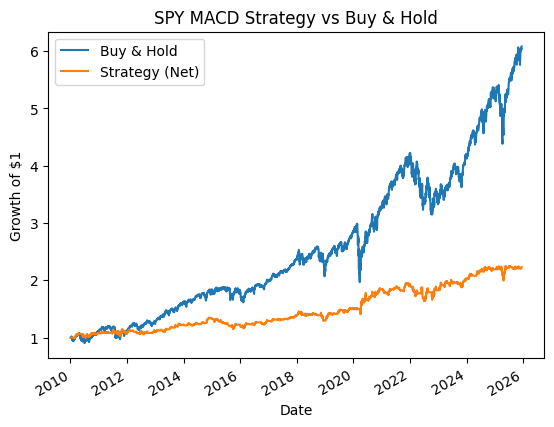

<Figure size 640x480 with 0 Axes>

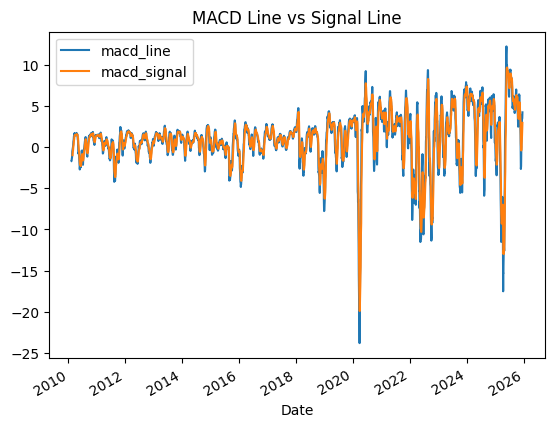

In [34]:
# ----------------------------
# Example: SPY MACD backtest with benchmark plot
# ----------------------------
START_DATE = "2010-01-01"
END_DATE = "2025-12-12"

df = download_price("SPY", start=START_DATE, end=END_DATE)

close = get_price_column(df, "Close")  # robust: Series even if df has MultiIndex cols
ind = macd(close, fast=12, slow=26, signal=9)
sig = macd_cross_long_flat(ind)

res = backtest_single_asset(
    price=df,
    raw_signal=sig,
    entry="next_close",  # or "next_open" if you want Open-based execution
    cost_bps=5.0,
    rf=0.0,
)

print("Strategy gross:", res["stats_gross_full"])
print("Strategy net:", res["stats_net_full"])
print("Benchmark (buy&hold):", res["stats_benchmark_full"])

# Plot equity vs benchmark
plt.figure()
res["benchmark_equity"].plot(label="Buy & Hold")
res["equity_net"].plot(label="Strategy (Net)")
plt.title("SPY MACD Strategy vs Buy & Hold")
plt.ylabel("Growth of $1")
plt.legend()
plt.show()

# Plot MACD lines
plt.figure()
ind[["macd_line", "macd_signal"]].plot()
plt.title("MACD Line vs Signal Line")
plt.show()

   fast  slow  signal         objective     score  train_ann_return_net  \
0    16    40       6  train_sharpe_net  0.820192              0.073860   
1    12    32       9  train_sharpe_net  0.797583              0.071275   
2    16    26      12  train_sharpe_net  0.788035              0.070663   
3    10    40       9  train_sharpe_net  0.775955              0.069059   
4     8    20       9  train_sharpe_net  0.772894              0.071181   
5    12    40       9  train_sharpe_net  0.771170              0.069321   
6    16    20      12  train_sharpe_net  0.763588              0.068226   
7     8    20       6  train_sharpe_net  0.761444              0.071663   
8    16    26       6  train_sharpe_net  0.758193              0.068838   
9     8    32      12  train_sharpe_net  0.754939              0.067724   

   train_ann_vol_net  train_sharpe_net  train_max_dd_net  train_n_obs  \
0           0.092060          0.820192         -0.124526         3020   
1           0.091594        

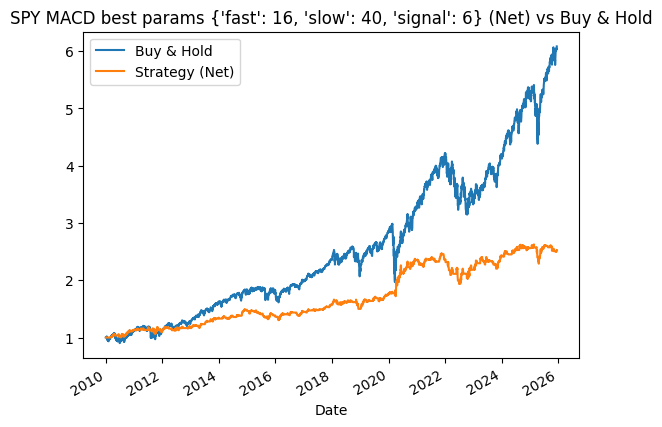

In [26]:
import yfinance as yf

START_DATE = "2010-01-01"
END_DATE   = "2025-12-12"

# Important: set auto_adjust explicitly to avoid default changes
df = yf.download("SPY", start=START_DATE, end=END_DATE, auto_adjust=False, progress=False).sort_index()

# Train/Test split
train_start, train_end = "2010-01-01", "2021-12-31"
test_start,  test_end  = "2022-01-01", "2025-12-12"

# 1) Find best MACD params on TRAIN
grid = find_best_macd_params(
    price=df,
    train_start=train_start, train_end=train_end,
    test_start=test_start, test_end=test_end,
    fast_grid=[8, 10, 12, 16],
    slow_grid=[20, 26, 32, 40],
    signal_grid=[6, 9, 12],
    entry="next_close",
    cost_bps=1.0,
    rf=0.0,
    objective="train_sharpe_net",
    min_train_obs=252
)

print(grid.head(10))

# 2) Backtest the best params on full history and view train/test stats
best = grid.iloc[0]
bt_best = build_and_backtest_best_macd(df, best, entry="next_close", cost_bps=1.0, rf=0.0)

stats_tt = train_test_stats(bt_best, train_start, train_end, test_start, test_end, rf=0.0)
print("Best params:", bt_best["best_params"])
print("TRAIN net:", stats_tt["train"]["net"])
print("TEST  net:", stats_tt["test"]["net"])

# 3) (Optional) plot equity vs benchmark
import matplotlib.pyplot as plt
plt.figure()
bt_best["benchmark_equity"].plot(label="Buy & Hold")
bt_best["equity_net"].plot(label="Strategy (Net)")
plt.title(f"SPY MACD best params {bt_best['best_params']} (Net) vs Buy & Hold")
plt.legend()
plt.show()
